In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfm, tfr = tf.math, tf.random

from scipy.stats import norm
from polyagamma import random_polyagamma

## Sampling PG random variables

In [13]:
from scipy.stats import norm, expon

In [14]:
__TRUNC = 0.64
__TRUNC_RECIP = 1.0 / __TRUNC
__PI = 3.141592653589793238462643383279502884197

In [15]:
def expon_mean(x):
    return np.random.exponential(x)
    
def expon_rate(rate):
    return expon_mean(1.0 / rate)

expon_rate(1.0)

1.1393444387823606

In [16]:
def a(n, x):
    K = (n + 0.5) * __PI
    y = 0
    if (x > __TRUNC):
        y = K * np.exp( -0.5 * K*K * x )
    elif (x > 0):
        expnt = -1.5 * (np.log(0.5 * __PI)  + np.log(x)) + np.log(K) - 2.0 * (n+0.5)*(n+0.5) / x
        y = np.exp(expnt)
        # y = pow(0.5 * __PI * x, -1.5) * K * exp( -2.0 * (n+0.5)*(n+0.5) / x);
        # ^- unstable for small x?
    return y

Z = np.random.normal(0, 1, size=(5,))
[a(1,x) for x in Z]

[0, 8.815360750016663e-05, 4.752489859638189e-09, 1.2863638699829978e-07, 0]

In [22]:
def mass_texpon(Z):
    t = __TRUNC

    fz = 0.125 * __PI*__PI + 0.5 * Z*Z
    b = np.sqrt(1.0 / t) * (t * Z - 1)
    a = np.sqrt(1.0 / t) * (t * Z + 1) * -1.0

    x0 = np.log(fz) + fz * t
    xb = x0 - Z + norm.logcdf(b)
    xa = x0 + Z + norm.logcdf(a)

    qdivp = 4 / __PI * ( np.exp(xb) + np.exp(xa) )

    return 1.0 / (1.0 + qdivp)

Z = np.random.normal(0, 1, size=(5,))
[mass_texpon(x) for x in Z]

[0.5759707408326631,
 0.5770896000716655,
 0.577587051549322,
 0.4328463538051182,
 0.5354566304468711]

In [23]:
def rtigauss(Z):
    Z = np.fabs(Z)
    t = __TRUNC
    X = t + 1.0
    if (__TRUNC_RECIP > Z): # mu > t
        alpha = 0.0
        while (np.random.uniform() > alpha):
            # X = t + 1.0;
            # while (X > t)
            # 	X = 1.0 / r.gamma_rate(0.5, 0.5);
            # Slightly faster to use truncated normal.
            E1 = expon_rate(1.0)
            E2 = expon_rate(1.0)
            while ( E1*E1 > 2 * E2 / t):
                E1 = expon_rate(1.0)
                E2 = expon_rate(1.0)
            X = 1 + E1 * t
            X = t / (X * X)
            alpha = np.exp(-0.5 * Z*Z * X)
    else:
        mu = 1.0 / Z
        while (X > t):
            Y = np.random.normal(1.0)
            Y *= Y
            half_mu = 0.5 * mu
            mu_Y    = mu  * Y
            X = mu + half_mu * mu_Y - half_mu * np.sqrt(4 * mu_Y + mu_Y * mu_Y)
            if (np.random.uniform() > mu / (mu + X)):
                X = mu*mu / X
    return X

Z = np.random.normal(0, 1, size=(5,))
[rtigauss(x) for x in Z]

[0.125966768348017,
 0.6063584198525717,
 0.6378608172192228,
 0.4921481932804687,
 0.45356574668944283]

In [24]:
def draw_like_devroye(Z):
    # Change the parameter.
    Z = np.fabs(Z) * 0.5

    # Now sample 0.25 * J^*(1, Z := Z/2).
    fz = 0.125 * __PI*__PI + 0.5 * Z*Z
    # ... Problems with large Z?  Try using q_over_p.
    # double p  = 0.5 * __PI * exp(-1.0 * fz * __TRUNC) / fz;
    # double q  = 2 * exp(-1.0 * Z) * pigauss(__TRUNC, Z);

    X = 0.0
    S = 1.0
    Y = 0.0
    # int iter = 0; If you want to keep track of iterations.

    while (True):

        # if (r.unif() < p/(p+q))
        if ( np.random.uniform() < mass_texpon(Z) ):
            X = __TRUNC + expon_rate(1) / fz
        else:
            X = rtigauss(Z)

        S = a(0, X)
        Y = np.random.uniform() * S
        n = 0
        go = True

        # Cap the number of iterations?
        while (go):

            # Break infinite loop.  Put first so it always checks n==0.
            #ifdef USE_R
            #if (n % 1000 == 0) R_CheckUserInterrupt();
            #endif

            n += 1
            if (n%2==1):
                S = S - a(n, X)
                if ( Y<=S ):
                    return 0.25 * X
            else:
                S = S + a(n, X)
                if ( Y>S ):
                    go = False
                    
        # Need Y <= S in event that Y = S, e.g. when X = 0.

Z = np.random.normal(0, 1, size=(5,))
[draw_like_devroye(x) for x in Z]

[0.4371826895563695,
 0.16400530158874663,
 0.35880383354745526,
 0.6071049476756947,
 0.1037132194012459]

In [25]:
def multi_pgdraw(n, Z):
    return np.sum([draw_like_devroye(Z) for i in range(n)])

multi_pgdraw(10, 0.5)

3.2944085972194737

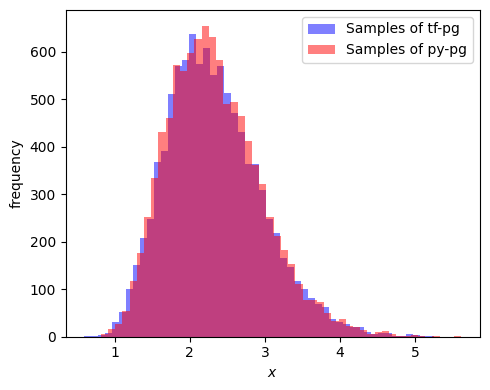

In [26]:
n = 10
Z = np.random.normal(0, 1, size=(10000,))
xs = [multi_pgdraw(n,x) for x in Z]
xx = random_polyagamma(n, Z, disable_checks=True)

# Plot the results
plt.figure(figsize=(5,4))
plt.hist(xs, 50, color='b', alpha=0.5, label="Samples of tf-pg")
plt.hist(xx, 50, color='r', alpha=0.5, label="Samples of py-pg")
#plt.plot(xx, post, '-b', lw=2, label="$p(x | y)$")
ylim = plt.ylim()
#plt.plot([x_true, x_true], ylim, '-r', lw=2, label="True $x$")
plt.ylim(ylim)
plt.xlabel("$x$")
plt.ylabel("frequency")
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
#plt.savefig("aux/binomial.png")
plt.show()